In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Imports
import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
# import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass

import sys
module_path = 'src' 
if module_path not in sys.path:
    sys.path.append(module_path)

# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

from utils import *
from parameters import *

In [2]:
# Some lists of nicknames for mice
UnrewNames=['B5','B6','B7','D3','D4','D5','D6','D7','D8','D9']
RewNames=['B1','B2','B3','B4','C1','C3','C6','C7','C8','C9']
AllNames=RewNames+UnrewNames
UnrewNamesSub=['B5','B6','B7','D3','D4','D5','D7','D8','D9'] # excluding D6 which barely entered the maze

In [3]:
# List number of bouts for each animal
print('mouse  bouts')
to=0
max_bouts = 0
for nickname in AllNames:
    tf = LoadTraj(nickname+'-tf')
    print(nickname+'     ',len(tf.no))
    
    if len(tf.no) > max_bouts:
        max_bouts = len(tf.no)
        
    to+=len(tf.no)
print('Total  ',to)
print('Max    ',max_bouts)

mouse  bouts
B1      104
B2      166
B3      147
B4      238
C1      173
C3      339
C6      150
C7      135
C8      164
C9      127
B5      245
B6      223
B7      204
D3      245
D4      319
D5      180
D6      59
D7      150
D8      109
D9      102
Total   3579
Max     339


In [4]:
nickname = "B1"
tf=LoadTraj(nickname+'-tf')
shape(tf.no), shape(tf.no[0])

/home/homero/software/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


((104,), (1, 2))

In [13]:
bout = 50
# frames in the bout when they visited the rwd_node
tf.no[bout][tf.no[bout][:,0]==RWD_NODE][:,1]

array([ 205, 1453, 2281, 3980])

## Waterport visits and reward consumption

In [2]:
nickname = "B1"
tf=LoadTraj(nickname+'-tf')
n_bouts = len(tf.no)
waterport_visits = [sum(tf.no[bout][:,0]==RWD_NODE) for bout in range(n_bouts)]
rwd_deliveries = [len(tf.re[bout]) for bout in range(n_bouts)]

Text(0, 0.5, 'Count')

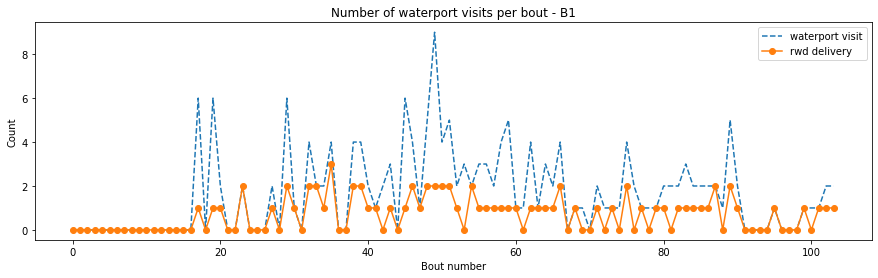

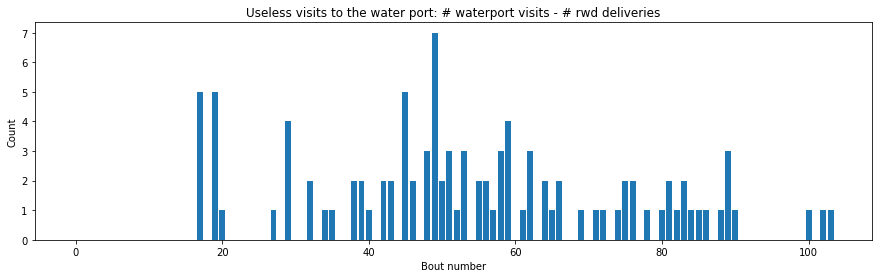

In [3]:
figure(figsize=(15,4))
width = .35
plt.plot(arange(n_bouts), waterport_visits, '--', label='waterport visit')
plt.plot(arange(n_bouts), rwd_deliveries, '-o', label='rwd delivery')
xlabel('Bout number')
ylabel('Count')
# xlim(0,100)
title('Number of waterport visits per bout - %s' % nickname)
legend()

useless_visits = array(waterport_visits)-(rwd_deliveries)
figure(figsize=(15,4))
title('Useless visits to the water port: # waterport visits - # rwd deliveries')
bar(arange(n_bouts), useless_visits)
xlabel('Bout number')
ylabel('Count')

(-0.5, 4.0)

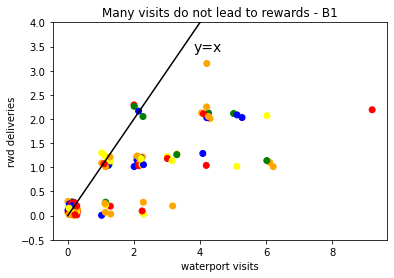

In [8]:
colors = ['red', 'green', 'blue', 'orange', 'yellow']
n_bouts = len(waterport_visits)
cs = random.choice(colors, n_bouts)
# cs = ['red', 'green', 'blue', 'orange', 'yellow']*34+['red', 'green', 'blue']

noise_lvl = .3
figure()
title("Many visits do not lead to rewards - %s" % nickname)
scatter(array(waterport_visits)+random.rand(n_bouts)*noise_lvl, array(rwd_deliveries)+random.rand(n_bouts)*noise_lvl, color=cs)
plt.plot(arange(10), arange(10), 'k')
xlabel('waterport visits')
ylabel('rwd deliveries')
text(3.8,3.4,"y=x", fontsize=14)
ylim(-.5, 4)

# figure()
# scatter(array(waterport_visits), array(rwd_deliveries), color=cs)
# plt.plot(arange(10), arange(10), 'k')
# xlabel('waterport visits')
# ylabel('rwd deliveries')

# Waterport visit intervals

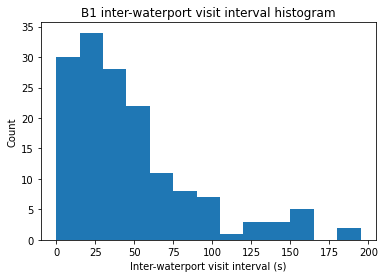

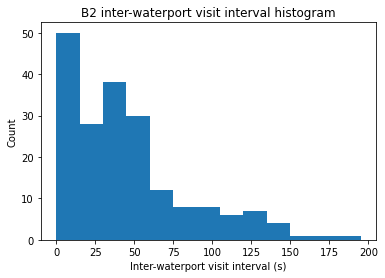

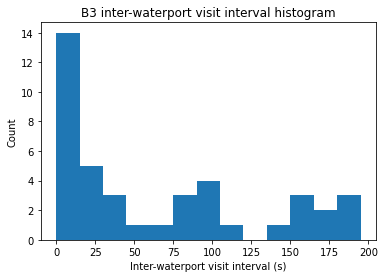

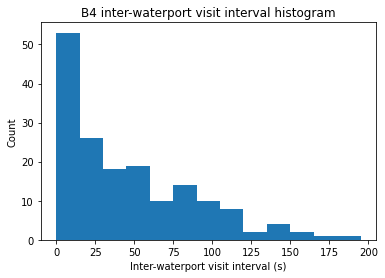

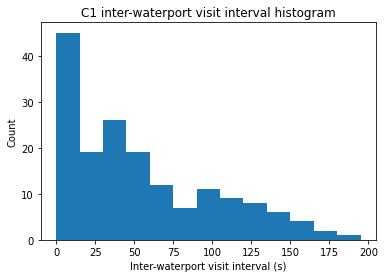

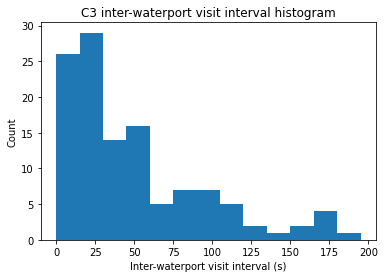

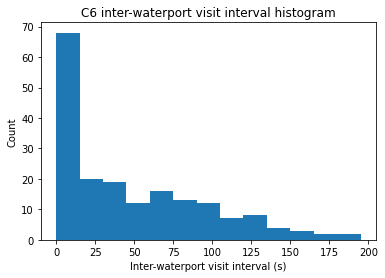

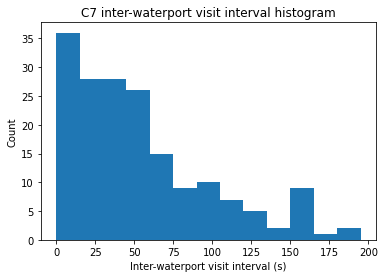

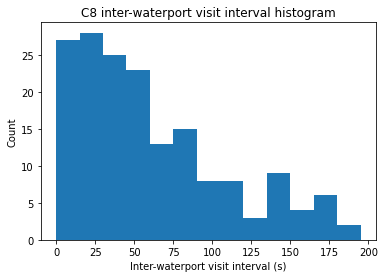

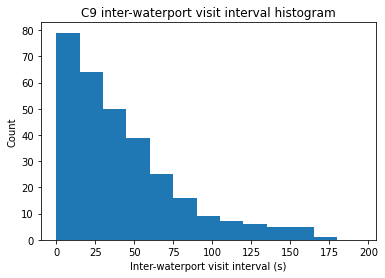

In [12]:
for nickname in RewNames:
# for nickname in AllNames:  # there is some error, gotta check later
    tf=LoadTraj(nickname+'-tf')
    
    # get waterport visits frames
    frs_to_waterport_visits = []
    for bout in range(n_bouts):
        rwd_node_visits_frs = tf.no[bout][tf.no[bout][:,0]==rwd_node]
        if len(rwd_node_visits_frs)>0:
            bout_init_fr = tf.fr[bout,0]
            frs_to_waterport_visits.append(bout_init_fr + rwd_node_visits_frs[:,1])

    frs_to_waterport_visits = np.concatenate(frs_to_waterport_visits)

    mazetimes_to_waterport_visits = np.array([TimeInMaze(frame_to_waterport_visit,tf) 
                                             for frame_to_waterport_visit in frs_to_waterport_visits])
    times_to_waterport_visits = np.array([frame_to_waterport_visit / FRAME_RATE
                                             for frame_to_waterport_visit in frs_to_waterport_visits])
    
    plt.figure()
    plt.hist(times_to_waterport_visits[1:]-times_to_waterport_visits[:-1], bins=arange(0,200, 15))
    plt.title("%s inter-waterport visit interval histogram" % nickname)
    plt.xlabel('Inter-waterport visit interval (s)')
    plt.ylabel('Count')
#     ylim(0,100)
#     plt.figure()
#     plt.hist(mazetimes_to_waterport_visits[1:]-mazetimes_to_waterport_visits[:-1], bins=arange(0,200, 15), color='g')
#     plt.title("%s inter-waterport visit mazetime interval histogram" % nickname)
#     plt.xlabel('Inter-waterport visit interval (s)')
#     plt.ylabel('Count')
# #     ylim(0,100)

# Reward delivery intervals

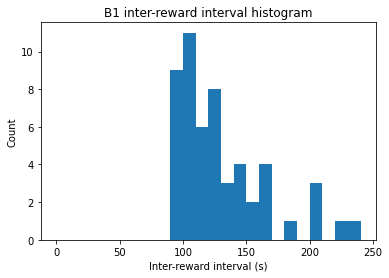

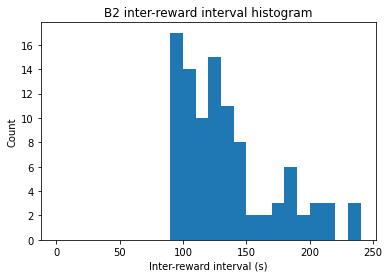

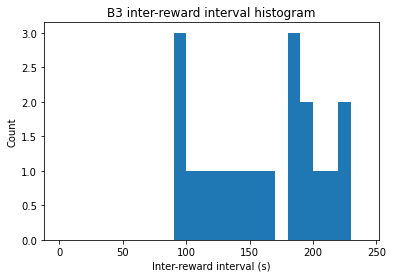

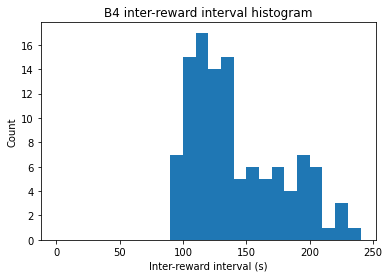

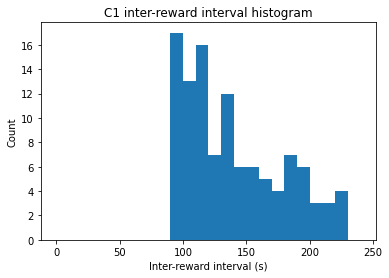

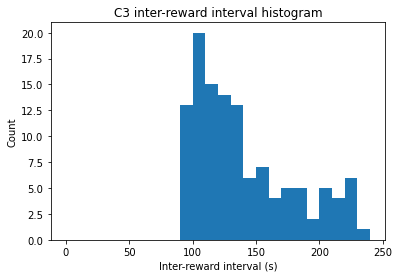

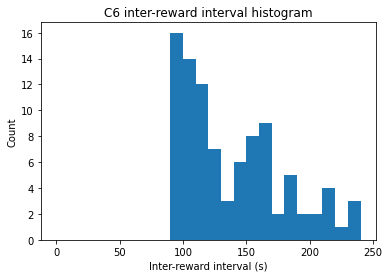

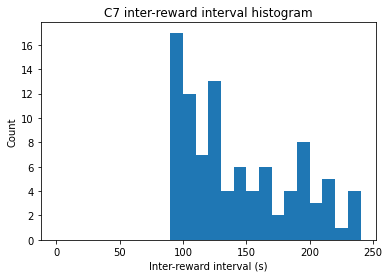

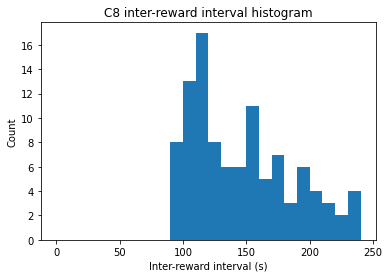

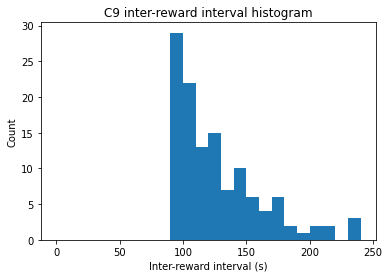

In [13]:
for nickname in RewNames:
# for nickname in AllNames:  # there is some error, gotta check later
    tf=LoadTraj(nickname+'-tf')
    # get all reward deliveries from all bouts
    frames_to_rwd = np.array([s_e_frs_of_each_rwd[0]+tf.fr[bout_idx,0] for bout_idx, frs_rwd in enumerate(tf.re) 
                                                                                        for s_e_frs_of_each_rwd in frs_rwd])
#     mazetimes_to_rwd = np.array([TimeInMaze(frame_to_rwd,tf) for frame_to_rwd in frames_to_rwd])
    times_to_rwd = np.array([frame_to_rwd/FRAME_RATE for frame_to_rwd in frames_to_rwd])
    plt.figure()
#     plt.hist(mazetimes_to_rwd[1:]-mazetimes_to_rwd[:-1], bins=arange(0,200, 15))
    plt.hist(times_to_rwd[1:]-times_to_rwd[:-1], bins=arange(0,250, 10))
    plt.title("%s inter-reward interval histogram" % nickname)
    plt.xlabel('Inter-reward interval (s)')
    plt.ylabel('Count')

If plotting histograms for time on maze (`mazetimes_to_rwd`): there are times smaller than 90s. It means that the animal spent time at the home cage instead of at the maze.

## Plotting rwd deliveries and waterport visits for one animal

(24870.166666666668, 24869.666666666668)

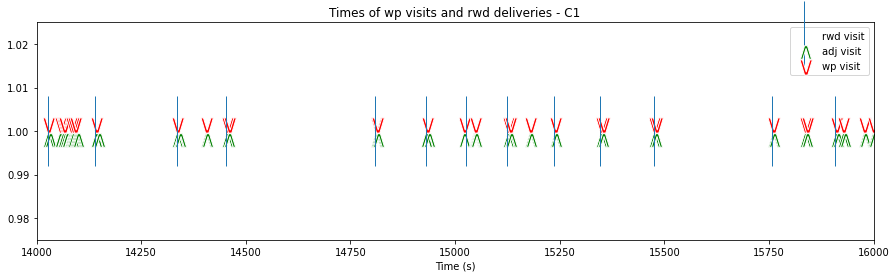

In [31]:
# %matplotlib qt
%matplotlib inline
nickname = "C1"
tf=LoadTraj(nickname+'-tf')

times_to_waterport_visits, times_to_rwd = get_wp_visit_times_and_rwd_times(tf)
times_to_adj_node = get_node_visit_times(tf, 57)

init_time=14000
time_window=2000

figure(figsize=(15,4))
plt.plot(times_to_rwd, ones(len(times_to_rwd)), '|', markersize=70, label='rwd visit')
# plt.plot(times_to_waterport_visits, ones(len(times_to_waterport_visits))+.01*(random.rand(len(times_to_waterport_visits))), '.', marker=7, markersize=15, label='wp visit')
# plt.plot(times_to_adj_node, ones(len(times_to_adj_node))-.001*(random.rand(len(times_to_adj_node))), '.', marker=6, markersize=10, label='adj visit')
plt.scatter(times_to_adj_node, ones(len(times_to_adj_node))-.002, marker=r'$\wedge$', s=200, label='adj visit', color='green', edgecolors='white', linewidths=1)
plt.scatter(times_to_waterport_visits, ones(len(times_to_waterport_visits))+.0015, marker=r'$\vee$', s=250, label='wp visit', color='red', edgecolors='white', linewidths=1)
# marker=r'$\wedge$'
plt.xlim(init_time, init_time+time_window)
plt.ylim(0.975, 1.025)
plt.title("Times of wp visits and rwd deliveries - %s" % nickname)
plt.xlabel("Time (s)")
legend()
times_to_rwd[-1], times_to_waterport_visits[-1]

## For all animals

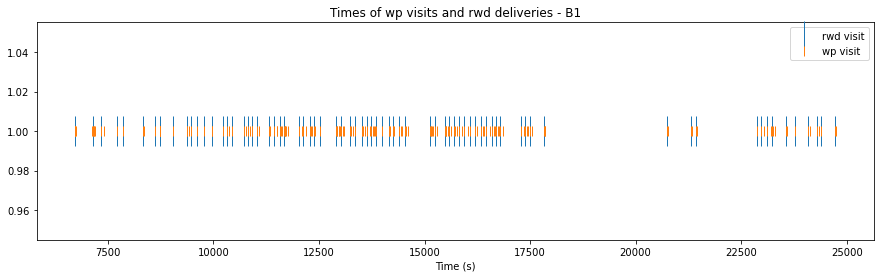

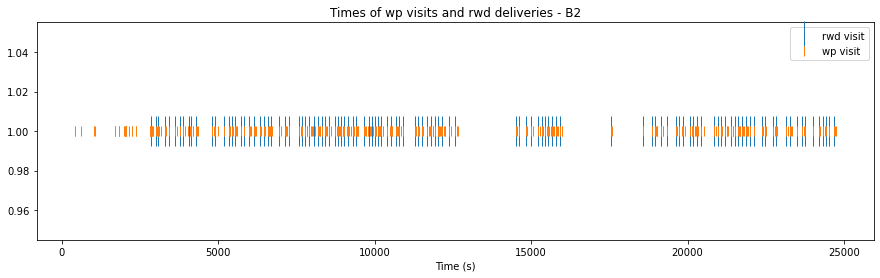

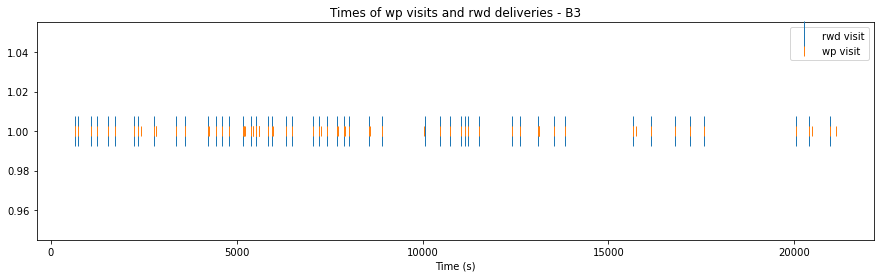

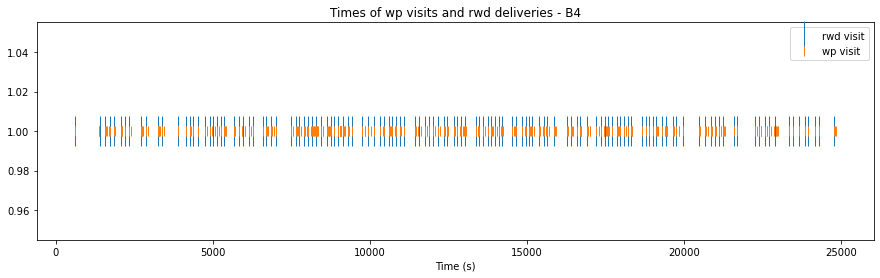

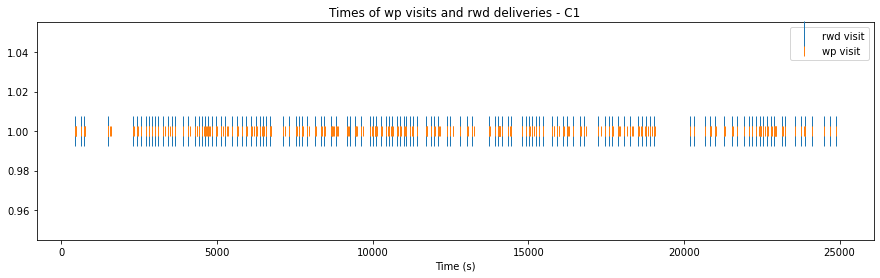

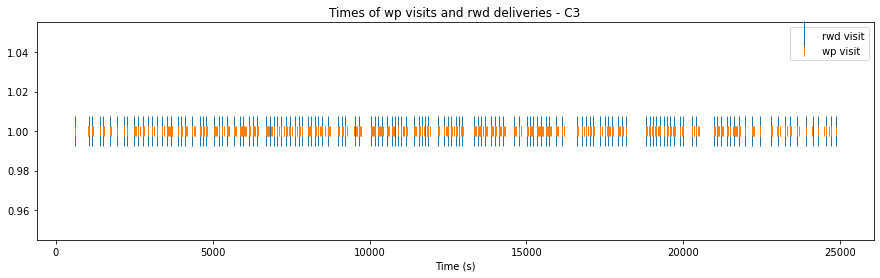

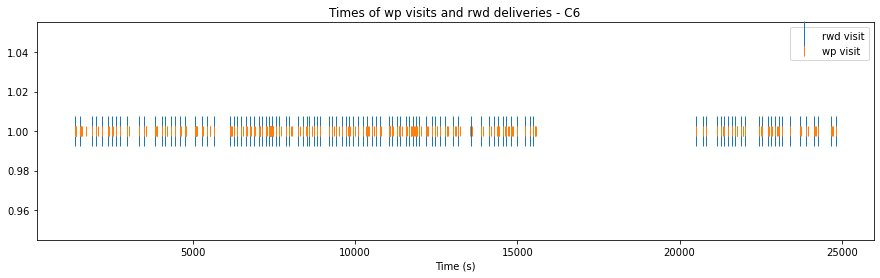

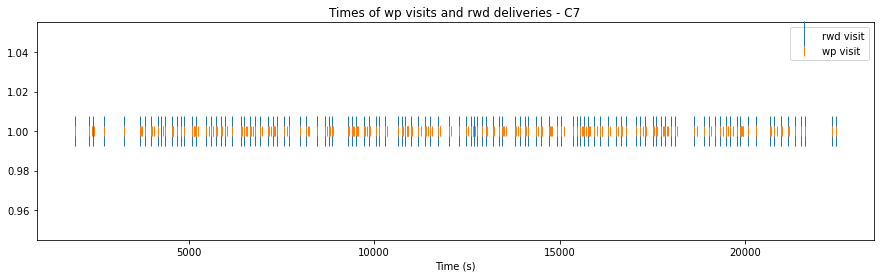

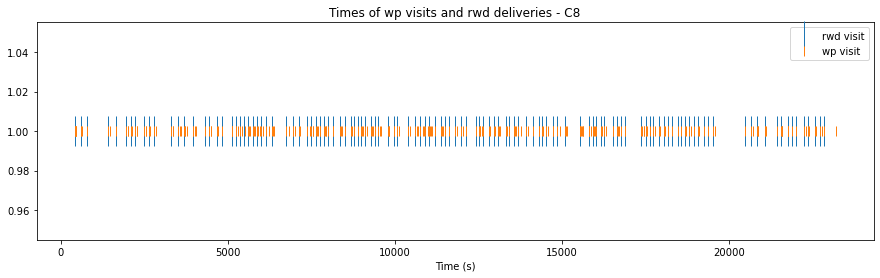

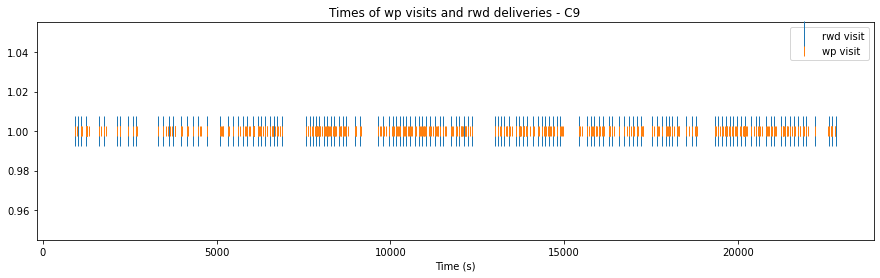

In [4]:
for nickname in RewNames:
# for nickname in AllNames:  # there is some error, gotta check later
    tf=LoadTraj(nickname+'-tf')
#     nickname = "B2"
#     tf=LoadTraj(nickname+'-tf')

    times_to_waterport_visits, times_to_rwd = get_wp_visit_times_and_rwd_times(tf)

    init_time=0
    time_window=None

    figure(figsize=(15,4))
    plt.plot(times_to_rwd, ones(len(times_to_rwd)), '|', markersize=30, label='rwd visit')
    plt.plot(times_to_waterport_visits, ones(len(times_to_waterport_visits)), '|', markersize=10, label='wp visit')
#     xlim(init_time, init_time+time_window)
    title("Times of wp visits and rwd deliveries - %s" % nickname)
    xlabel("Time (s)")
    legend()


### sanity check
waterport and reward consumption times

In [93]:
print("first waterport visit before first reward (as it should):")
for nickname in RewNames:
    tf=LoadTraj(nickname+'-tf')
    
    times_to_waterport_visits, times_to_rwd = get_wp_visit_times_and_rwd_times(tf)

    all_waterport_visits = create_list_waterport_visits_in_between_rwds(times_to_waterport_visits, times_to_rwd)
    
    print(nickname, times_to_waterport_visits[0]-times_to_rwd[0]<0)
    

print("last waterport visit after last reward:")
for nickname in RewNames:
    tf=LoadTraj(nickname+'-tf')
    times_to_waterport_visits, times_to_rwd = get_wp_visit_times_and_rwd_times(tf)
    all_waterport_visits = create_list_waterport_visits_in_between_rwds(times_to_waterport_visits, times_to_rwd)
    
    
    print(nickname, str(times_to_waterport_visits[-1]-times_to_rwd[-1]>=0).ljust(5), "|", 
          "len(times_to_rwd) %3d" % len(times_to_rwd), "len(all_waterport_visits) %3d" % len(all_waterport_visits), 
          "Same?", len(times_to_rwd)==len(all_waterport_visits))
    
    # check that create_list_waterport_visits_in_between_rwds removes the wp visits after last rwd

first waterport visit before first reward (as it should):
B1 True
B2 True
B3 True
B4 True
C1 True
C3 True
C6 True
C7 True
C8 True
C9 True
last waterport visit after last reward:
B1 True  | len(times_to_rwd)  74 len(all_waterport_visits)  74 Same? True
B2 True  | len(times_to_rwd) 115 len(all_waterport_visits) 115 Same? True
B3 True  | len(times_to_rwd)  50 len(all_waterport_visits)  50 Same? True
B4 True  | len(times_to_rwd) 133 len(all_waterport_visits) 133 Same? True
C1 False | len(times_to_rwd) 133 len(all_waterport_visits) 133 Same? True
C3 False | len(times_to_rwd) 143 len(all_waterport_visits) 143 Same? True
C6 False | len(times_to_rwd) 112 len(all_waterport_visits) 112 Same? True
C7 False | len(times_to_rwd) 115 len(all_waterport_visits) 115 Same? True
C8 True  | len(times_to_rwd) 123 len(all_waterport_visits) 123 Same? True
C9 False | len(times_to_rwd) 138 len(all_waterport_visits) 138 Same? True


### Visualize tf.no with time in seconds for each node visit

In [140]:
nickname = "C3"
tf=LoadTraj(nickname+'-tf')

tf_new = add_node_times_to_tf(tf)
# tf_new.node_times

## First visits after rwd delivery

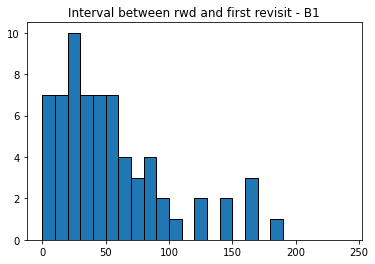

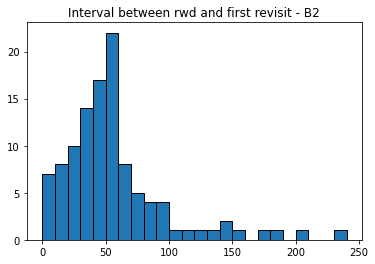

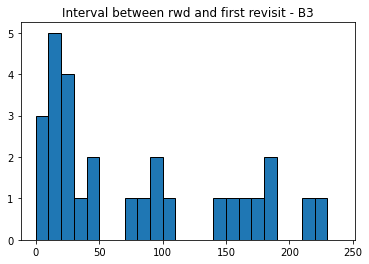

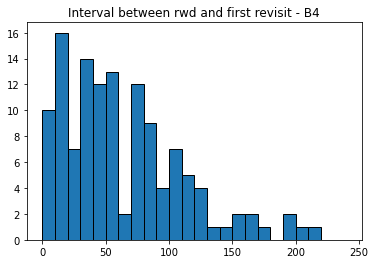

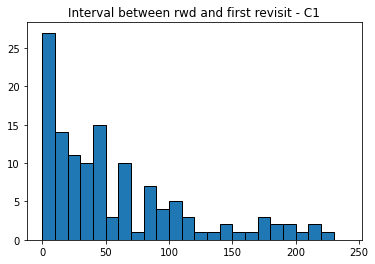

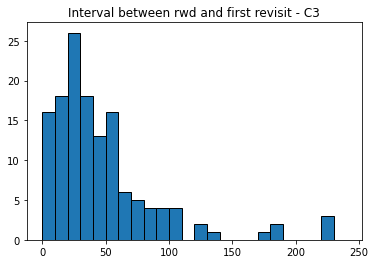

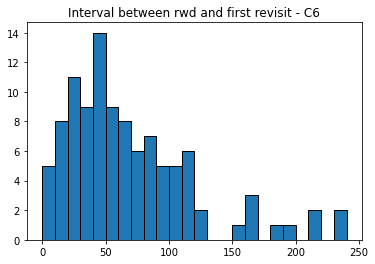

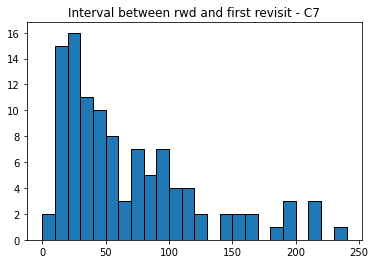

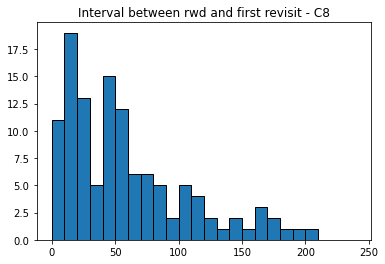

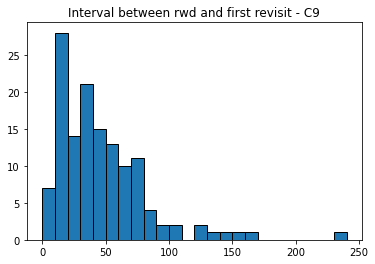

In [39]:
for nickname in RewNames:
# for nickname in AllNames:  # there is some error, gotta check later
    tf=LoadTraj(nickname+'-tf')
# nickname = "B2"
# tf=LoadTraj(nickname+'-tf')

    times_to_waterport_visits, times_to_rwd = get_wp_visit_times_and_rwd_times(tf)

    all_waterport_visits = create_list_waterport_visits_in_between_rwds(times_to_waterport_visits, times_to_rwd)

    first_visits_after_rwd = [waterport_visits_in_between_rwds[0] for waterport_visits_in_between_rwds in all_waterport_visits[1:]]  # :1 removes visits before the first reward was received
    n_inter_rwds = len(first_visits_after_rwd)  # used because there is a mismatch between visits

    plt.figure()
    plt.hist(np.array(first_visits_after_rwd) - times_to_rwd[:n_inter_rwds], bins=arange(0,250, 10), ec='black')
    plt.title("Interval between rwd and first revisit - %s" % nickname)

In [41]:
len(all_waterport_visits), len(times_to_rwd), len(first_visits_after_rwd)

(138, 138, 137)

## Amount of wp visits in between rwds

In [25]:
lll= array([1,2,4,6])


array([1, 2, 4, 6, 0, 0, 0, 0, 0, 0])

Text(0.5, 0, 'rwd visit number')

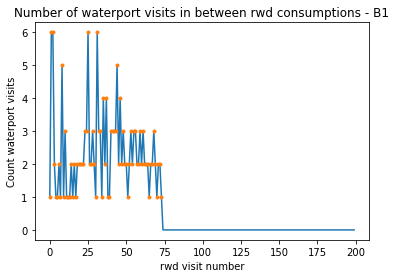

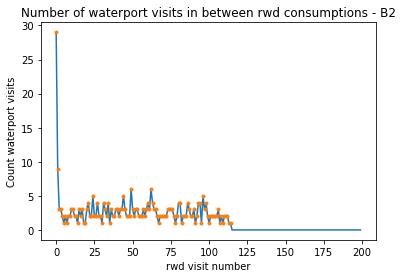

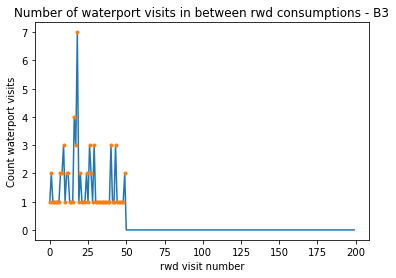

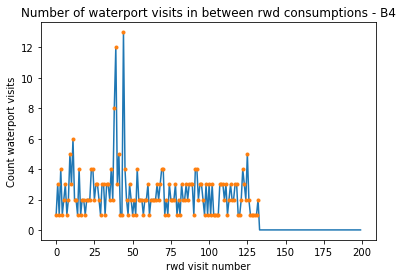

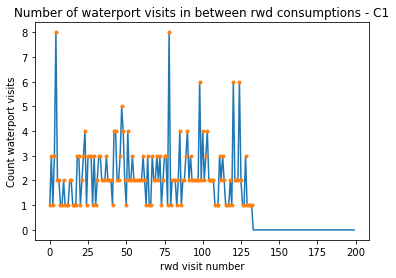

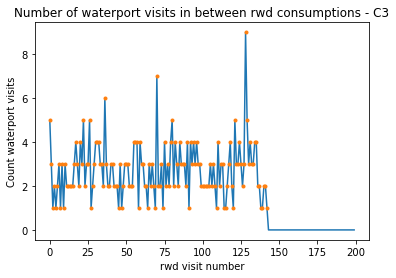

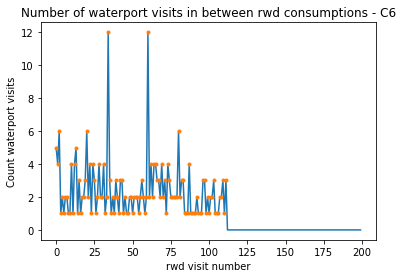

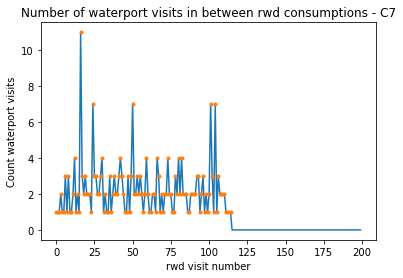

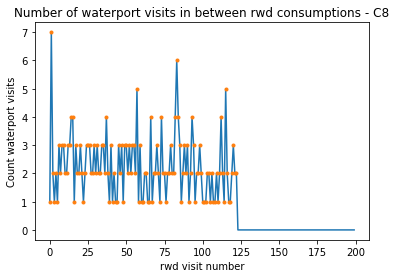

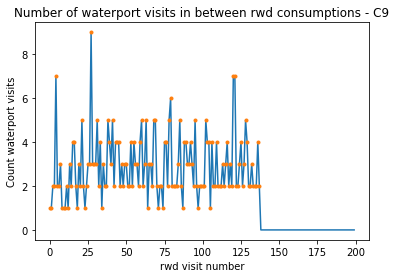

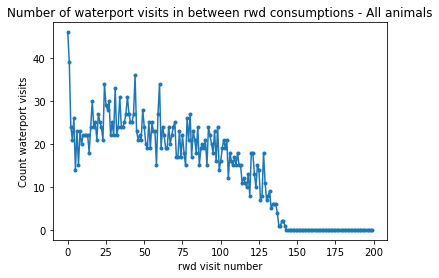

In [33]:
all_animals_count = zeros(200)
for nickname in RewNames:
    tf=LoadTraj(nickname+'-tf')
    times_to_waterport_visits, times_to_rwd = get_wp_visit_times_and_rwd_times(tf)
    all_waterport_visits = create_list_waterport_visits_in_between_rwds(times_to_waterport_visits, times_to_rwd)
    plt.figure()
    wp_visit_count_in_bw_rwds = array([len(waterport_visits_in_bw_rwds) 
                                       for waterport_visits_in_bw_rwds in all_waterport_visits])
    all_animals_count += pad(wp_visit_count_in_bw_rwds,(0,200-len(wp_visit_count_in_bw_rwds)), 'constant')
    plt.plot(pad(wp_visit_count_in_bw_rwds,(0,200-len(wp_visit_count_in_bw_rwds)), 'constant'))
    plt.plot(wp_visit_count_in_bw_rwds, '.')
    plt.title("Number of waterport visits in between rwd consumptions - %s" % nickname)
    plt.ylabel("Count waterport visits")
    plt.xlabel("rwd visit number")

figure()
plt.plot(all_animals_count, '.-')
plt.title("Number of waterport visits in between rwd consumptions - All animals")
plt.ylabel("Count waterport visits")
plt.xlabel("rwd visit number")

## Cumulative times to a visit after each reward

Text(0.5, 0, 'Time(s)')

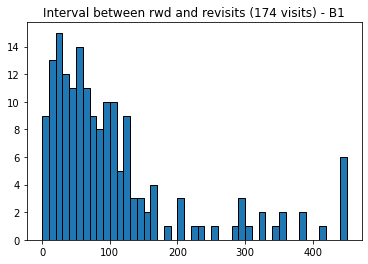

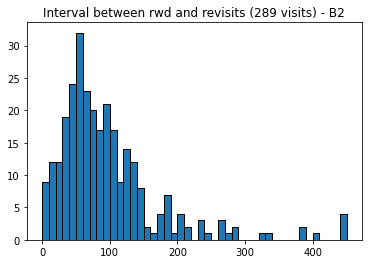

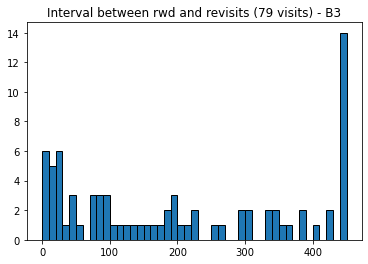

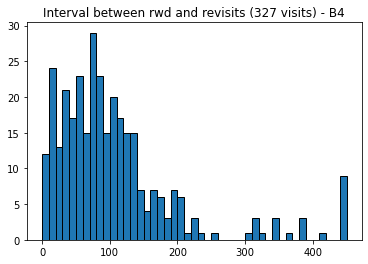

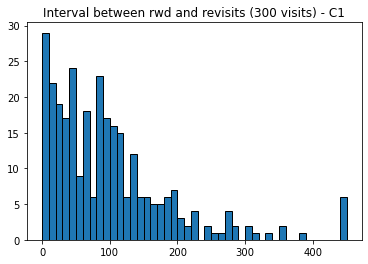

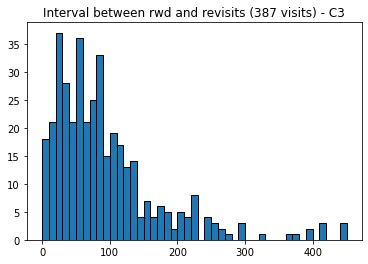

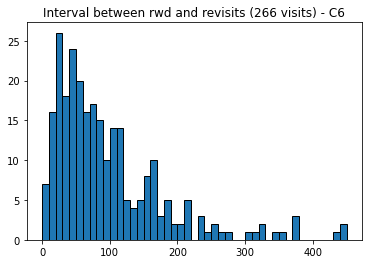

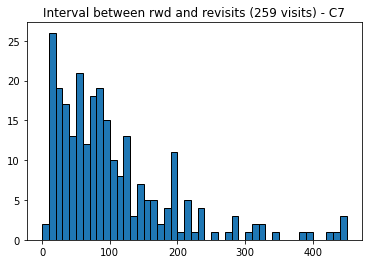

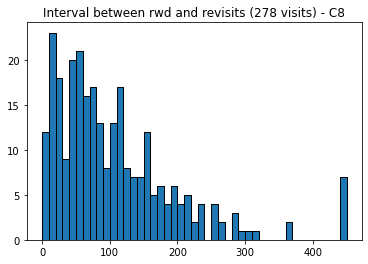

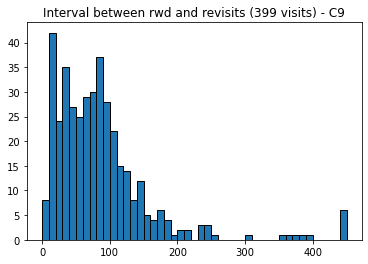

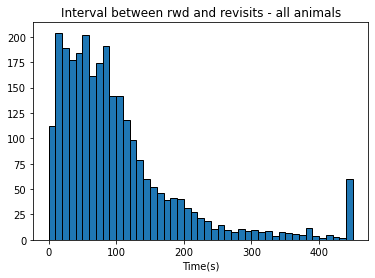

In [40]:
all_animals = []
for nickname in RewNames:
# for nickname in AllNames:  # there is some error, gotta check later
    tf=LoadTraj(nickname+'-tf')
    
# nickname = "B2"
# tf=LoadTraj(nickname+'-tf')

    times_to_waterport_visits, times_to_rwd = get_wp_visit_times_and_rwd_times(tf)

    
    all_waterport_visits = create_list_waterport_visits_in_between_rwds(times_to_waterport_visits, times_to_rwd)
    
    

    cum_times_wp_visits = []
    for wp_visits_i, wp_visits_bw_rwds in enumerate(all_waterport_visits[1:]): # disconsider waterport visits before the first reward
        cum_times_wp_visits.append(wp_visits_bw_rwds-times_to_rwd[wp_visits_i])

    plt.figure()
#     plt.title("Interval between rwd and revisits - %s" % nickname)
    plt.title("Interval between rwd and revisits (%d visits) - %s" % (len(np.concatenate(cum_times_wp_visits)),nickname))
    plt.hist(clip(concatenate(cum_times_wp_visits), 0, 450), bins=arange(0,460, 10), ec='black')
#     plt.hist(np.concatenate(cum_times_wp_visits), bins=arange(0,250, 10), ec='black')
    
    all_animals.append(np.concatenate(cum_times_wp_visits))

## FOR ALL ANIMALS
plt.figure()
plt.hist(clip(concatenate(all_animals), 0, 450), bins=arange(0,460, 10), ec='black')
plt.title("Interval between rwd and revisits - all animals")
plt.xlabel("Time(s)")

### First half of the night

Text(0.5, 0, 'Time(s)')

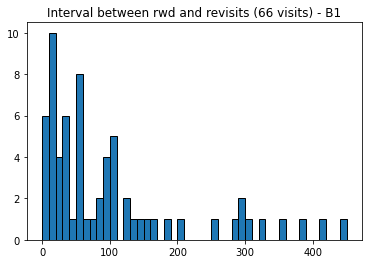

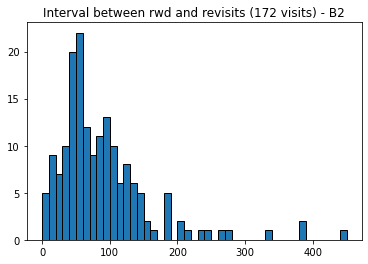

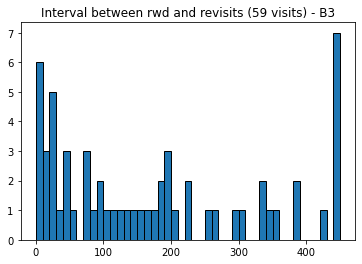

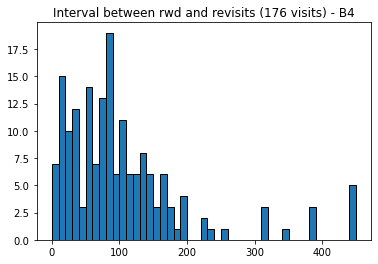

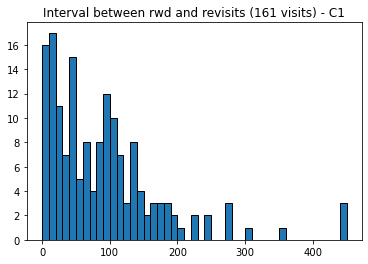

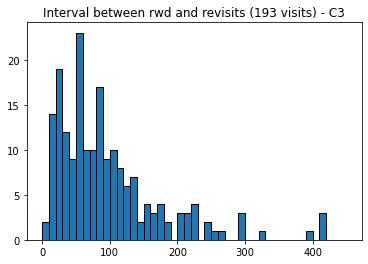

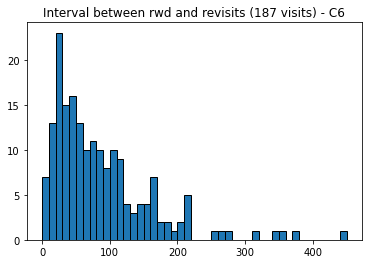

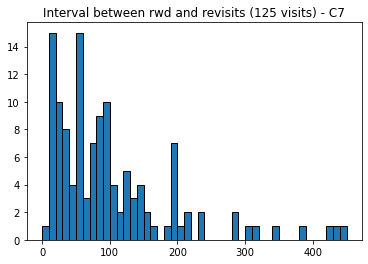

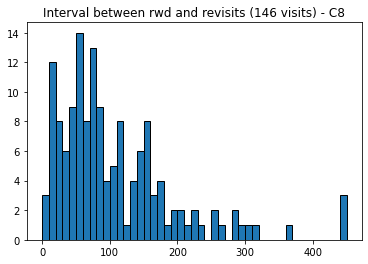

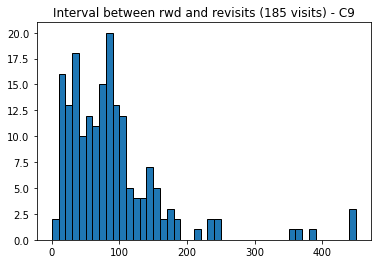

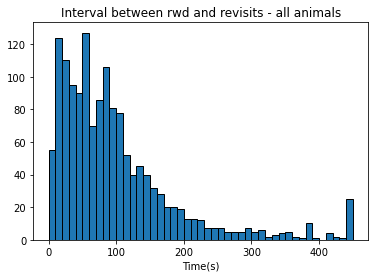

In [127]:
all_animals = []
for nickname in RewNames:
    tf=LoadTraj(nickname+'-tf')
# nickname = "B2"
# tf=LoadTraj(nickname+'-tf')
    times_to_waterport_visits, times_to_rwd = get_wp_visit_times_and_rwd_times(tf)    
    all_waterport_visits = create_list_waterport_visits_in_between_rwds(times_to_waterport_visits, times_to_rwd)
    len(all_waterport_visits), len(times_to_rwd)
    midpoint = tf.fr[-1,-1]/FRAME_RATE/2

    rwd_idxs_1st_half = where(times_to_rwd<midpoint)[0]
    times_to_rwd_1st_half = times_to_rwd[rwd_idxs_1st_half]
#     print(len(times_to_rwd_1st_half))
    wp_idxs_1st_half = rwd_idxs_1st_half + 1  # + 1 because we want to analyse visits to waterport after each reward (and the first list is before the first list of visits is before the first rwd)
    wp_visits_1st_half = all_waterport_visits[wp_idxs_1st_half.min():wp_idxs_1st_half.max()+1]
#     print(len(wp_visits_1st_half))

    cum_times_wp_visits = []
    for wp_visits_i, wp_visits_bw_rwds in enumerate(wp_visits_1st_half):
    #     print(wp_visits_i, len(wp_visits_1st_half), len(times_to_rwd_1st_half))
        cum_times_wp_visits.append(wp_visits_bw_rwds-times_to_rwd_1st_half[wp_visits_i])

    plt.figure()
    plt.hist(clip(concatenate(cum_times_wp_visits), 0, 450), bins=arange(0,460, 10), ec='black')
    plt.title("Interval between rwd and revisits (%d visits) - %s" % (len(np.concatenate(cum_times_wp_visits)),nickname))
    
    all_animals.append(np.concatenate(cum_times_wp_visits))

## FOR ALL ANIMALS
plt.figure()
plt.hist(clip(concatenate(all_animals), 0, 450), bins=arange(0,460, 10), ec='black')
plt.title("Interval between rwd and revisits - all animals")
plt.xlabel("Time(s)")

check if the above is correct (the indexes)

### Second half of the night

Text(0.5, 0, 'Time(s)')

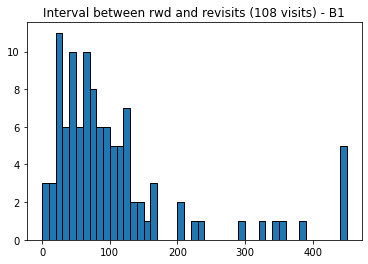

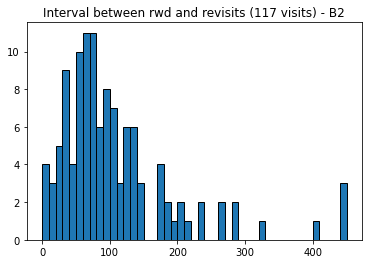

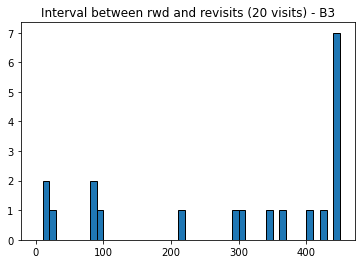

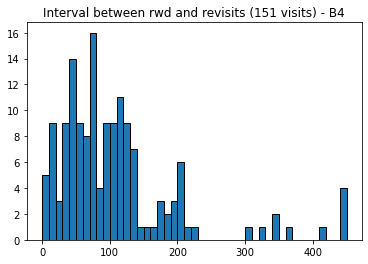

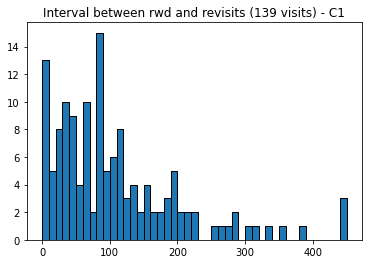

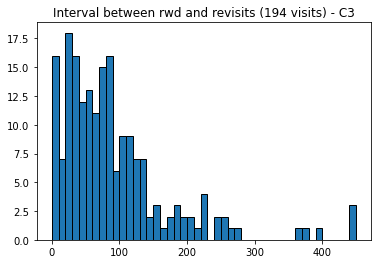

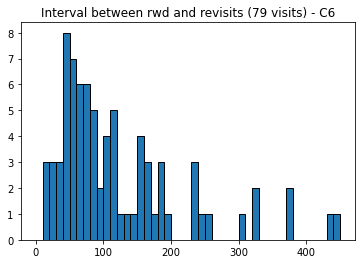

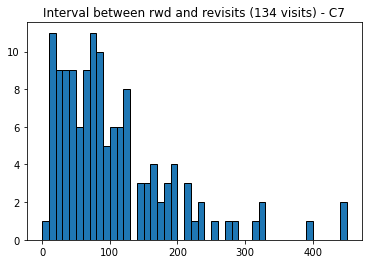

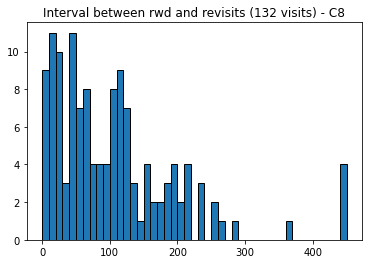

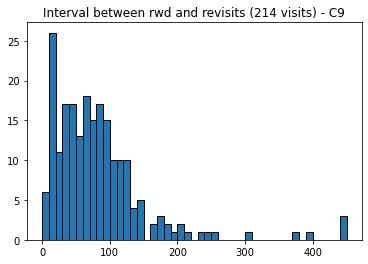

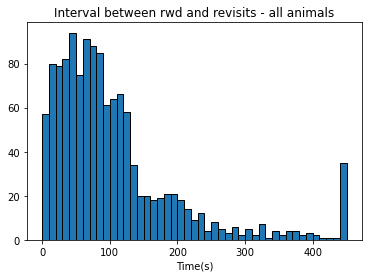

In [139]:
all_animals = []
for nickname in RewNames:
    tf=LoadTraj(nickname+'-tf')
#     nickname = "B2"
    tf=LoadTraj(nickname+'-tf')
    times_to_waterport_visits, times_to_rwd = get_wp_visit_times_and_rwd_times(tf)    
    all_waterport_visits = create_list_waterport_visits_in_between_rwds(times_to_waterport_visits, times_to_rwd)
    len(all_waterport_visits), len(times_to_rwd)
    midpoint = tf.fr[-1,-1]/FRAME_RATE/2

    rwd_idxs_2nd_half = where(times_to_rwd>=midpoint)[0]
    times_to_rwd_2nd_half = times_to_rwd[rwd_idxs_2nd_half][:-1]  # remove last rwd time because we won't analyse any wp visits after that
#     print(len(times_to_rwd_2nd_half))
    wp_idxs_2nd_half = rwd_idxs_2nd_half + 1  # + 1 because we want to analyse visits to waterport after first reward
    wp_visits_2nd_half = all_waterport_visits[wp_idxs_2nd_half.min():wp_idxs_2nd_half.max()+1]
#     print(len(wp_visits_2nd_half))
    
    cum_times_wp_visits = []
    for wp_visits_i, wp_visits_bw_rwds in enumerate(wp_visits_2nd_half):
    #     print(wp_visits_i, len(wp_visits_2nd_half), len(times_to_rwd_2nd_half))
        cum_times_wp_visits.append(wp_visits_bw_rwds-times_to_rwd_2nd_half[wp_visits_i])

    plt.figure()
    plt.hist(clip(concatenate(cum_times_wp_visits), 0, 450), bins=arange(0,460, 10), ec='black')
    plt.title("Interval between rwd and revisits (%d visits) - %s" % (len(np.concatenate(cum_times_wp_visits)),nickname))
    
    all_animals.append(np.concatenate(cum_times_wp_visits))

## FOR ALL ANIMALS
plt.figure()
plt.hist(clip(concatenate(all_animals), 0, 450), bins=arange(0,460, 10), ec='black')
plt.title("Interval between rwd and revisits - all animals")
plt.xlabel("Time(s)")

## Fit a mixture distribution to the data

In [37]:
# import scipy
from scipy import stats
from scipy.stats import rv_continuous
class mix_exp_gaussian_cdf_dist(stats.rv_continuous):
    "Mixture of Exponential and Gaussian distribution"
    def _cdf(self, x, exp_scale, sigma, w):
        return w*stats.expon.cdf(x, scale=exp_scale) + (1-w) * stats.norm.cdf(x, loc=90, scale=sigma)
mix_cdf = mix_exp_gaussian_cdf_dist()

In [73]:
def grid_search(samples):
    max_e, max_s= 180, 50
    ll = zeros((max_e, max_s, 5))
    for i_w, w in enumerate([0, .25, .5, .75, 1]):
        print(w)
        for i_e, e in enumerate(range(1, max_e+1)):
            for i_s, s in enumerate(range(1, max_s+1)):
                ll[i_e, i_s, i_w] = sum(mix_cdf.logpdf(samples, exp_scale=e, sigma=s, w=w))
    return np.array(unravel_index(np.nanargmax(ll), ll.shape))+1, ll

In [74]:
params, ll = grid_search(np.concatenate(all_animals))
params, ll

0
0.25


<ipython-input-73-e1581cec909a>:8: RuntimeWarning: divide by zero encountered in log
  ll[i_e, i_s, i_w] = sum(log(mix_cdf.pdf(samples, exp_scale=e, sigma=s, w=w)))
<ipython-input-73-e1581cec909a>:8: RuntimeWarning: invalid value encountered in log
  ll[i_e, i_s, i_w] = sum(log(mix_cdf.pdf(samples, exp_scale=e, sigma=s, w=w)))


0.5
0.75
1


(array([117,  32,   4]),
 array([[[            nan,             nan,             nan,
                      nan,             nan],
         [            nan,             nan,             nan,
                      nan,             nan],
         [            nan,             nan,             nan,
                      nan,             nan],
         ...,
         [            nan,             nan,             nan,
                      nan,             nan],
         [            nan,             nan,             nan,
                      nan,             nan],
         [            nan,             nan,             nan,
                      nan,             nan]],
 
        [[            nan,             nan,             nan,
                      nan,             nan],
         [            nan,             nan,             nan,
                      nan,             nan],
         [            nan,             nan,             nan,
                      nan,             nan],
    

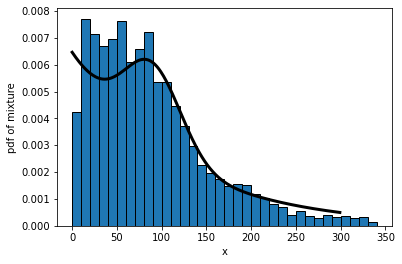

In [41]:
plt.plot(mix_cdf.pdf(np.arange(0.1, 300, 1), 117,  32,   .75), color='k', linewidth=3)
ylabel('pdf of mixture')
xlabel('x')

plt.hist(np.concatenate(all_animals), bins=arange(0,350, 10), ec='black', density=True);

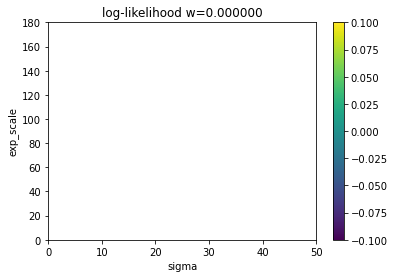

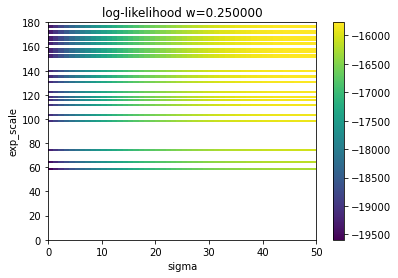

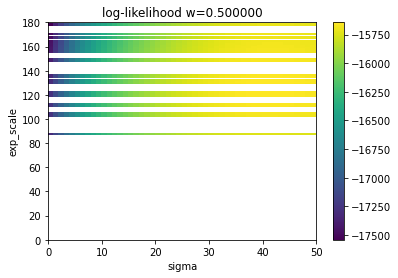

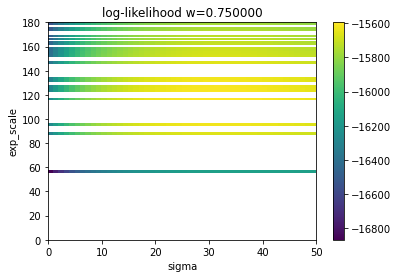

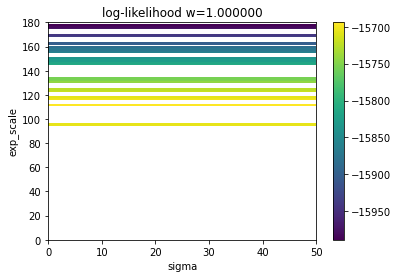

In [77]:
ws = [0, .25, .5, .75, 1]

for i in range(5):
    figure()
    pcolormesh(ll[:,:, i])
    title('log-likelihood w=%f' % ws[i])
    ylabel('exp_scale')
    xlabel('sigma')
    colorbar()

In [32]:
ll.shape

(40, 80)

In [26]:
grid_search(np.concatenate(all_animals))

<ipython-input-25-ca3727f5c201>:6: RuntimeWarning: divide by zero encountered in log
  ll[i_e, i_s] = sum(log(mix_cdf.pdf(samples, exp_scale=e, sigma=s)))
<ipython-input-25-ca3727f5c201>:6: RuntimeWarning: invalid value encountered in log
  ll[i_e, i_s] = sum(log(mix_cdf.pdf(samples, exp_scale=e, sigma=s)))


ValueError: All-NaN slice encountered

### Null model

Create synthetic data of a Poisson process of waterport visits. Assume that in the first visit after every 90s, the animal gets a reward. Create histograms similar to the ones above.

In [90]:
np.set_printoptions(precision=1)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380]),
 <BarContainer object of 38 artists>)

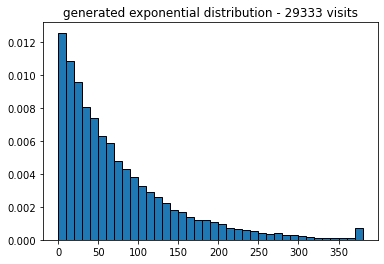

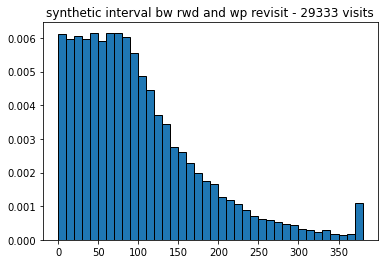

In [134]:
max_clip = 380

mean_ivi = 75  # mean inter-visit interval
total_time = 2200000  # total time in the maze ranges between 20000 and 25000 seconds
n_samples = int(total_time/mean_ivi)
synt_exp_visit_intervals = np.random.exponential(mean_ivi, n_samples)
plt.title("generated exponential distribution - %d visits" % len(synt_exp_visit_intervals))
plt.hist(clip(synt_exp_visit_intervals, 0, max_clip), bins=arange(0,max_clip+1, 10), ec='black', density=True)
# plt.ylim(0,50)



cumulated_intervals = cumsum(synt_exp_visit_intervals)
synt_wp_visit_intervals = zeros(len(cumulated_intervals))

# Reset cumulated count after 90s, as in waterport visits after rwd 90s timeout

# print(cumulated_intervals)
ref = cumulated_intervals
for idx in range(len(cumulated_intervals)):
    synt_wp_visit_intervals[idx] = ref[idx]
    if ref[idx]>=90:
        ref[idx+1:] = ref[idx+1:]-ref[idx]
synt_wp_visit_intervals=ref
# print(synt_wp_visit_intervals)

plt.figure()
plt.title("synthetic interval bw rwd and wp revisit - %d visits" % len(synt_wp_visit_intervals))
plt.hist(clip(synt_wp_visit_intervals, 0, max_clip), bins=arange(0, max_clip+1, 10), ec='black', density=True)
# plt.ylim(0,50)

## miscellaneous

In [ ]:
[el in (rwd_node,57) for el in tf.no[-1][:,0]]  # 57 is the node next to the rwd_node

In [ ]:
[el in (rwd_node, 57) for el in tf.no[bout][:,0]] 
bout_init_fr + rwd_node_visits_frs[:,1], 
rwd_node_visits_frs + np.array([[0, 1],[0,1]])*bout_init_fr